In [414]:
import re
from functools import partial
from glob import glob
import h5py
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.signal import argrelextrema
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from keras.preprocessing.sequence import pad_sequences
from imblearn.under_sampling import RandomUnderSampler

from rpy2 import robjects as robj
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr

from librosa.core import dtw

numpy2ri.activate()

dtwclust = importr('dtwclust')

In [386]:
signals = []
transcripts = []

for fast5 in glob('./nanopanel_reads/*.fast5'):
    transcript_id = re.search('ENST\d*', fast5).group(0)
    transcripts.append(transcript_id)
    f = h5py.File(fast5)
    read = f['Raw/Reads']
    read_0 = list(read.values())[0]
    signal = read_0['Signal'].value
    signal[(signal > 2000) | (signal < 0)] = np.median(signal)
    signals.append(scale(signal, axis=0))
    f.close()

transcripts_sorted_idx = np.argsort(transcripts)
transcripts = np.asarray(transcripts)[transcripts_sorted_idx]
signals = np.asarray(signals)[transcripts_sorted_idx]

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


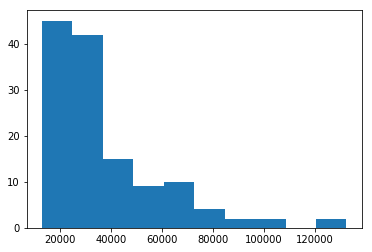

In [387]:
plt.hist([len(s) for s in signals])
plt.show()

In [448]:
def find_polyA(signal, start_max_order=500, end_min_order=50):
    assert signal.ndim == 1
    v = np.hstack([
        np.ones(signal.shape),
        np.ones(signal.shape) * -1
    ])
    conv = np.convolve(signal, v, mode='valid')
    polya_start = argrelextrema(conv,
                                np.greater,
                                order=start_max_order)[0][1]
    polya_start = int(polya_start)
    polya_end_candidates = argrelextrema(conv,
                                         np.less,
                                         order=end_min_order)[0]
    polya_end_idx = np.searchsorted(polya_end_candidates, polya_start)
    try:
        polya_end_idx = int(polya_end_idx)
    except ValueError:
        polya_end_idx = int(polya_end_idx[0])
    try:
        polya_end = polya_end_candidates[polya_end_idx]
    except IndexError:
        polya_end = polya_end_candidates[polya_end_idx - 1]
    return polya_end, conv


def crop_signal(signal, polya_end_idx):
    return signal[polya_end_idx: polya_end_idx + 750]


def cluster_signals(signals):
    def _dtw(X, Y):
        return dtw(X, Y,
                   metric='cityblock',
                   backtrack=False,
                   subseq=False,
                   global_constraints=True)[-1, -1]
    poly_a_ends = [find_polyA(sig)[0] for sig in signals]
    signal_slic = [crop_signal(sig, pa) for sig, pa in zip(signals, poly_a_ends)]
    dists = pdist(signal_slic, metric=_dtw)
    dists = squareform(dists)
    return dists

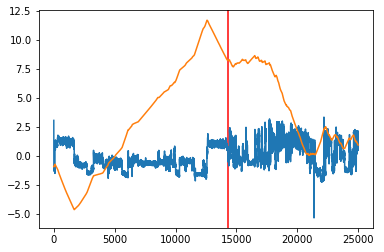

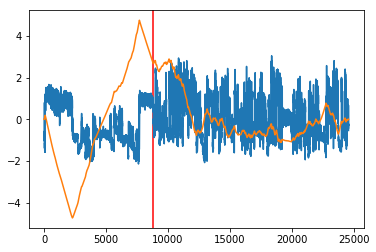

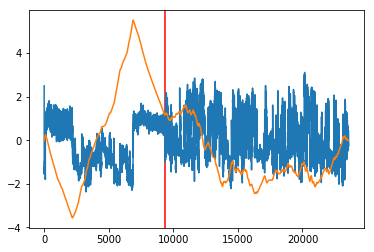

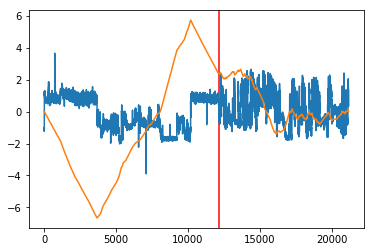

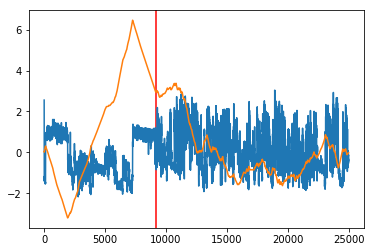

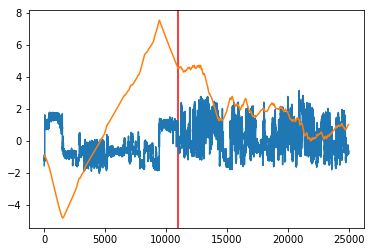

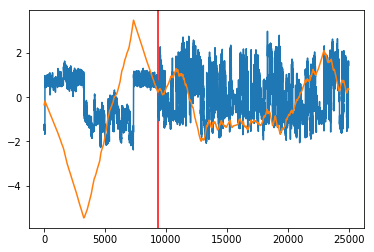

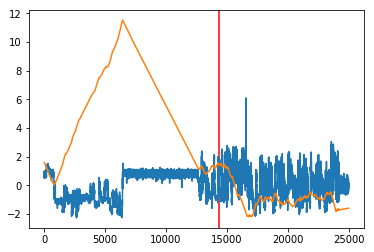

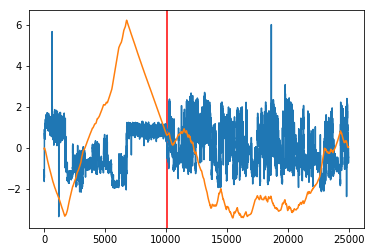

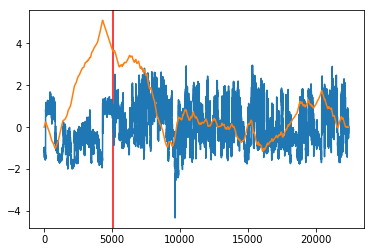

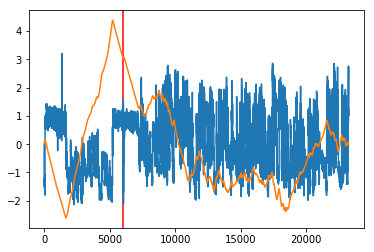

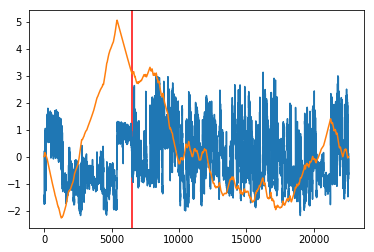

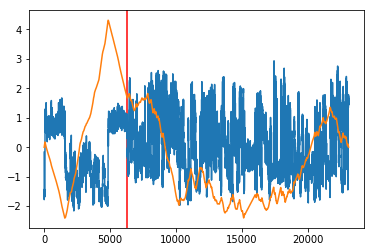

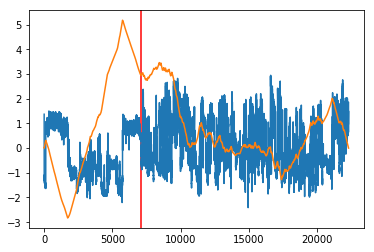

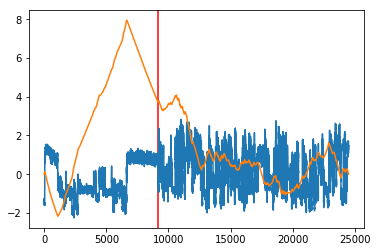

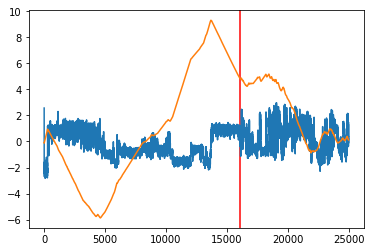

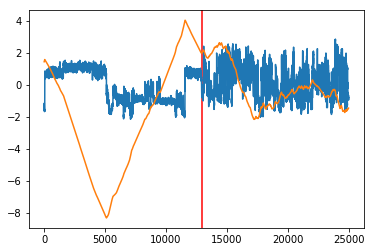

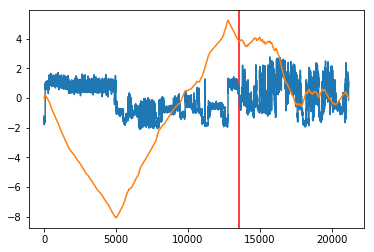

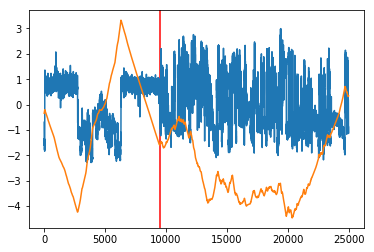

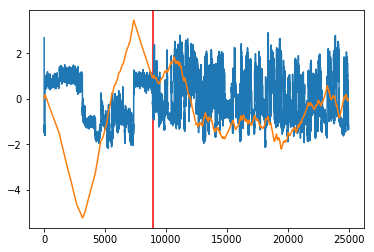

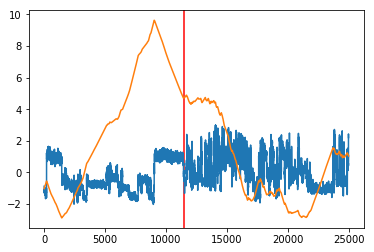

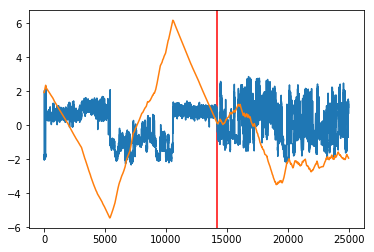

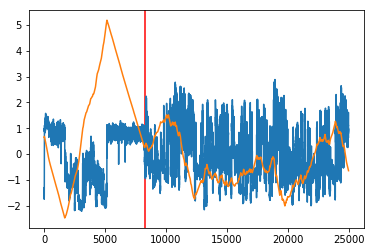

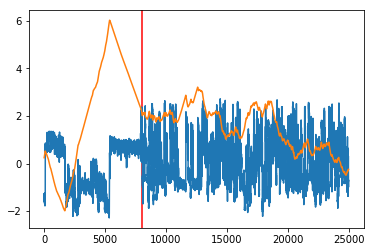

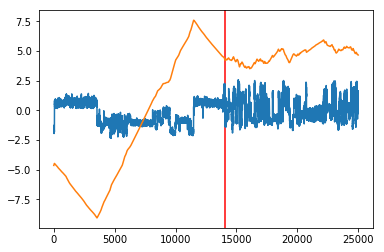

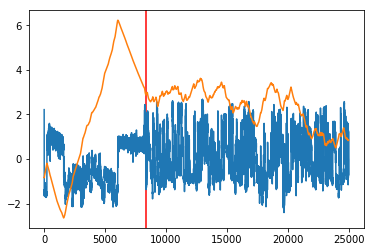

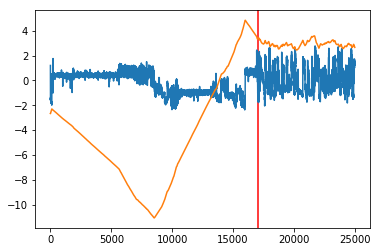

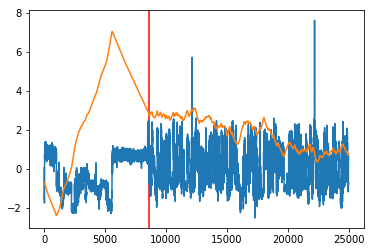

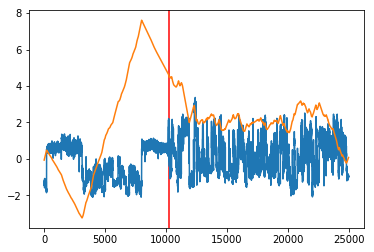

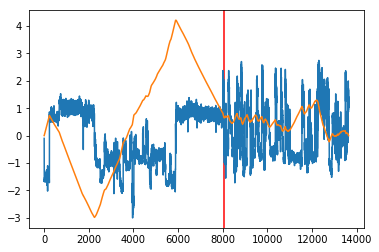

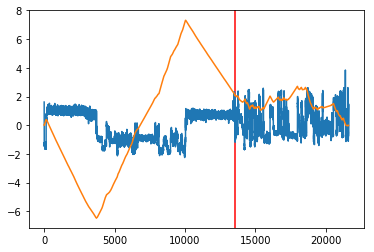

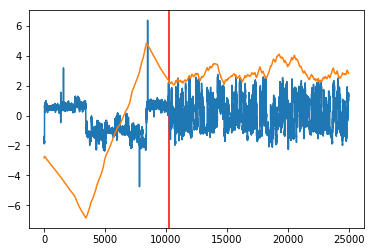

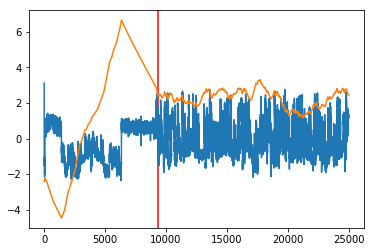

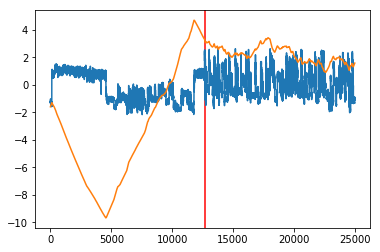

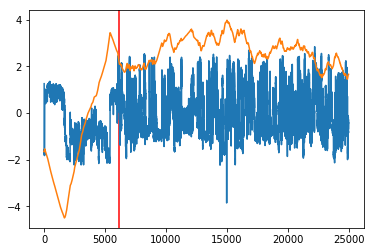

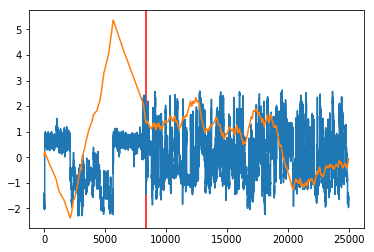

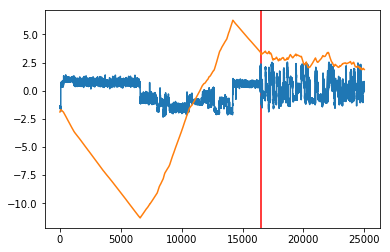

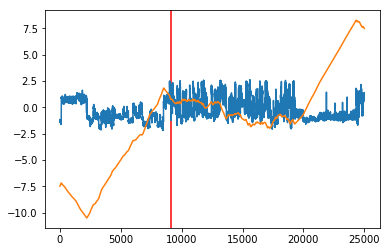

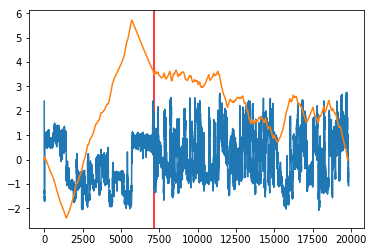

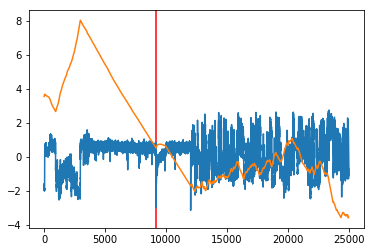

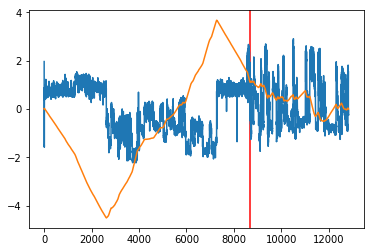

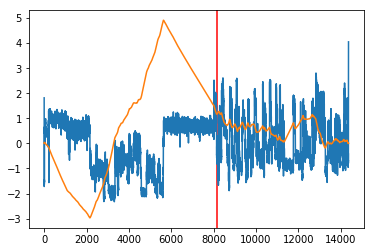

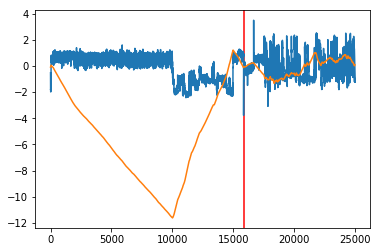

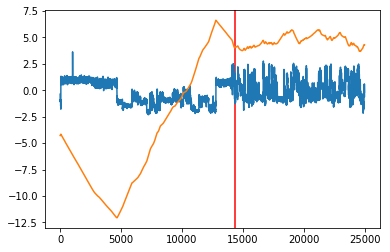

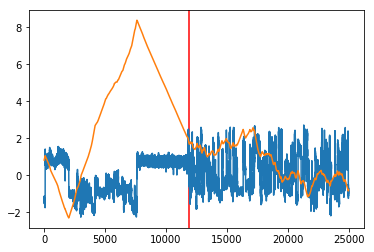

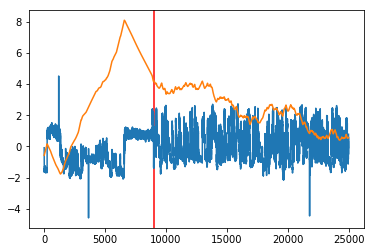

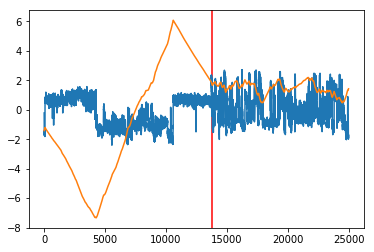

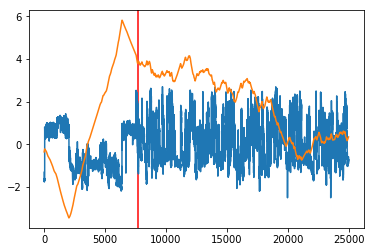

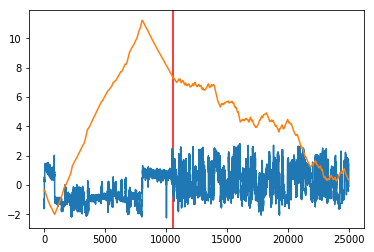

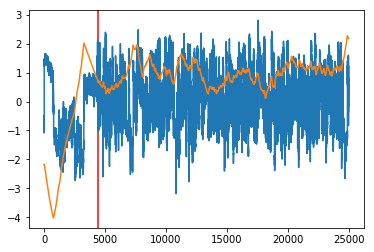

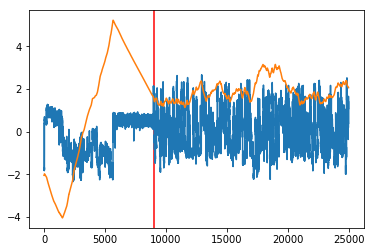

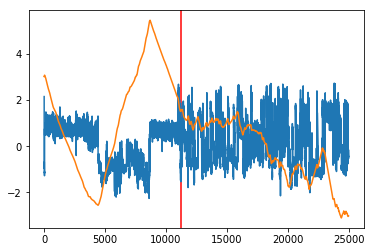

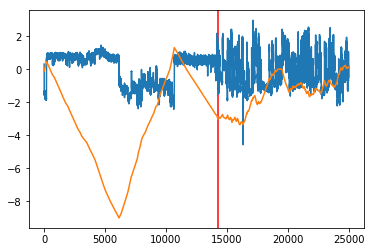

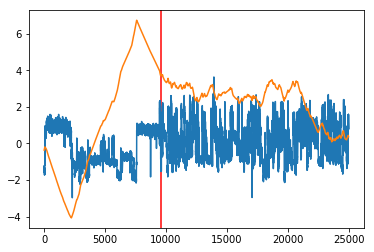

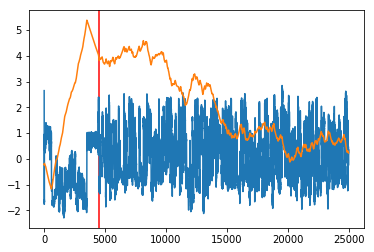

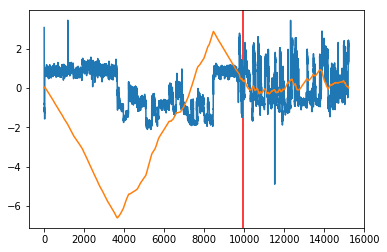

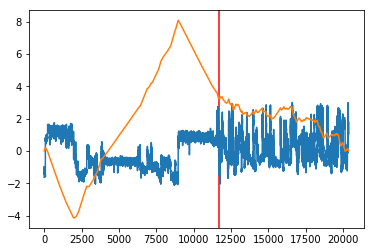

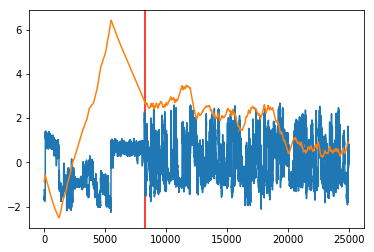

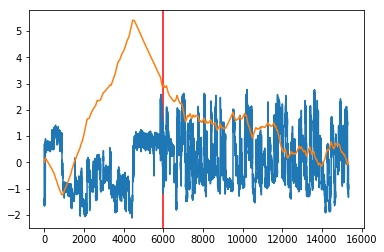

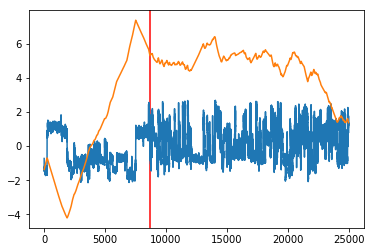

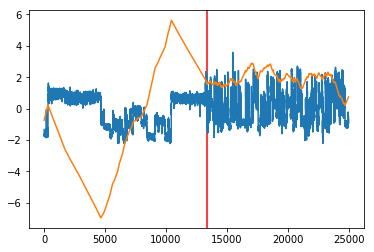

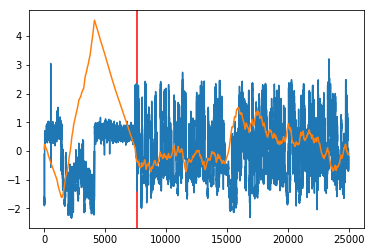

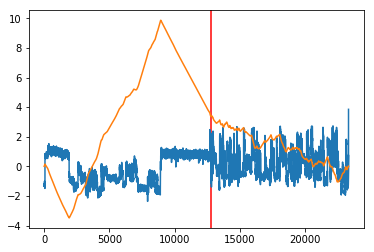

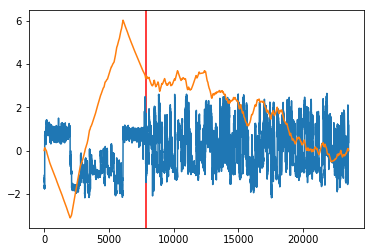

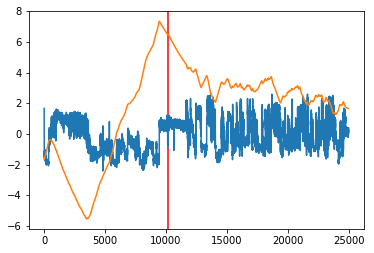

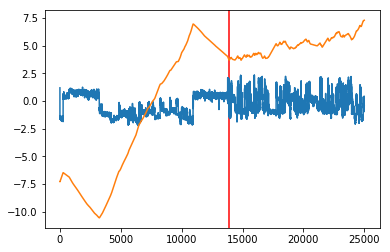

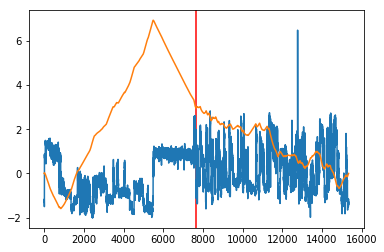

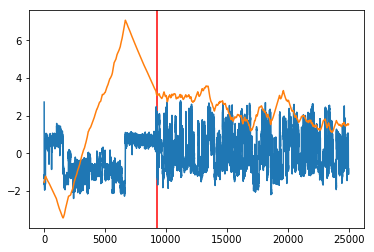

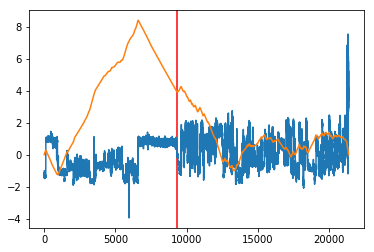

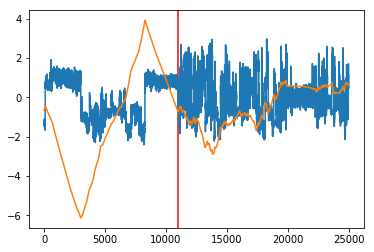

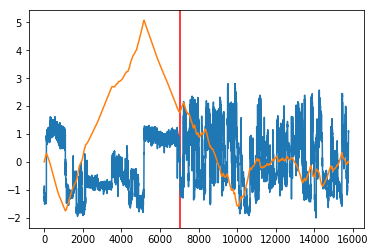

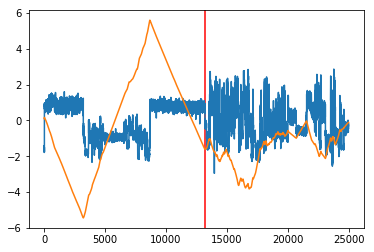

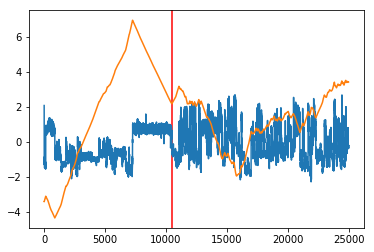

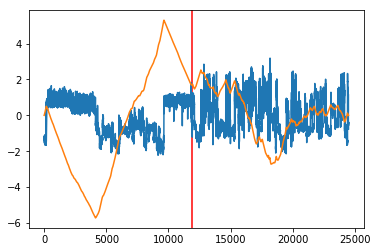

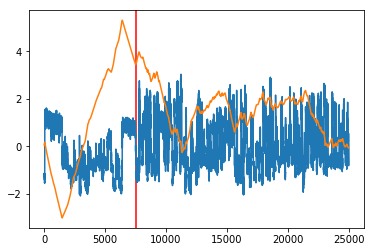

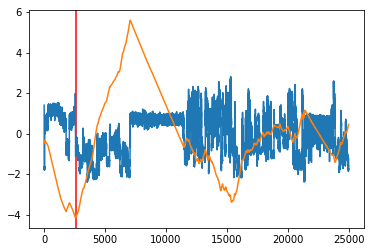

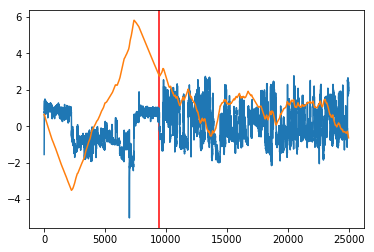

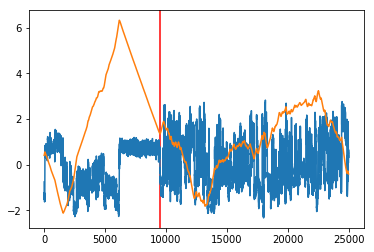

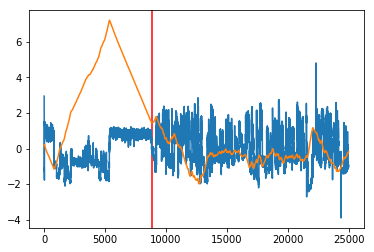

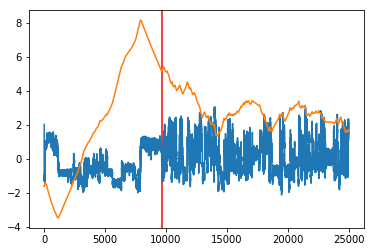

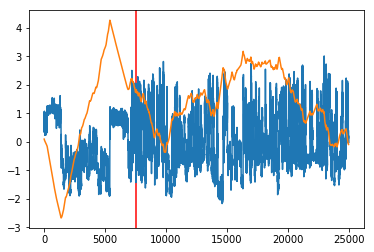

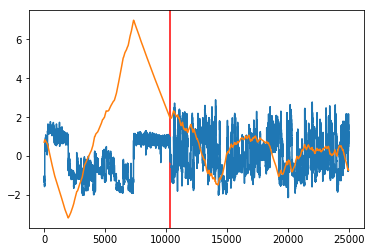

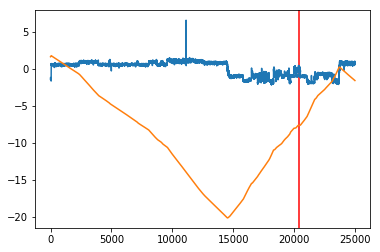

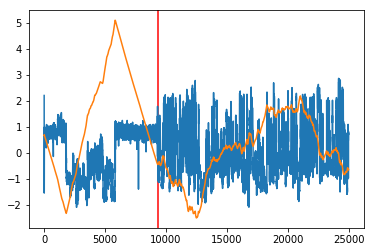

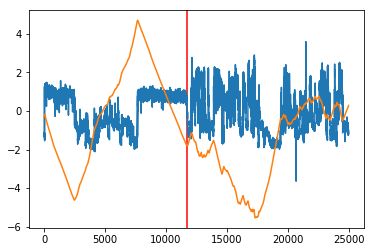

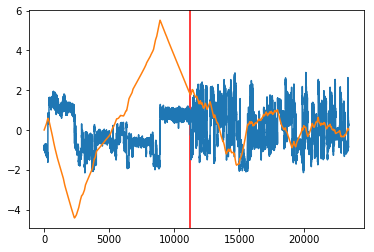

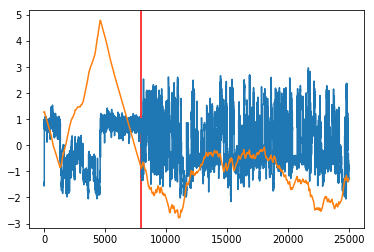

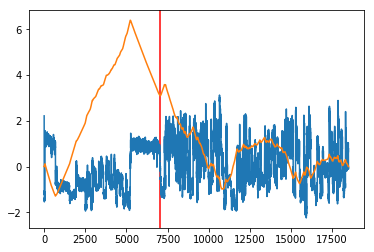

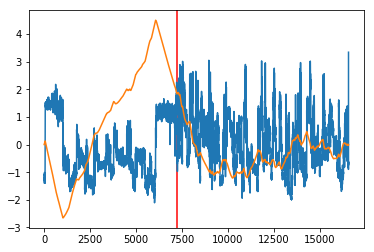

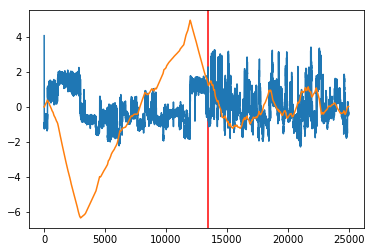

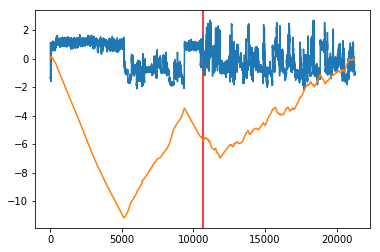

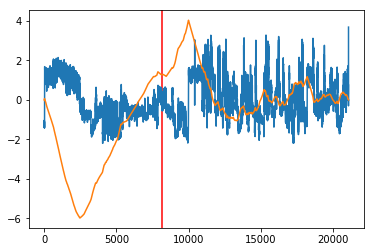

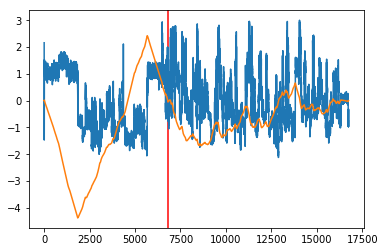

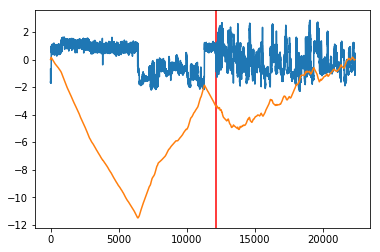

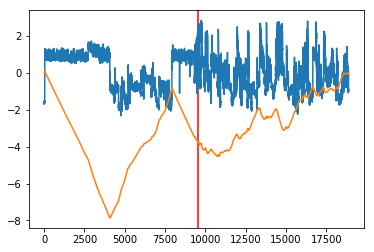

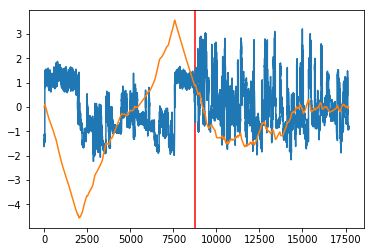

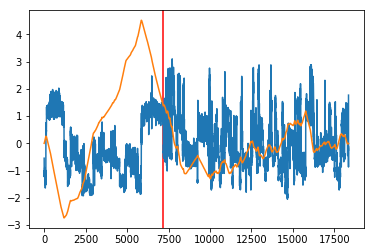

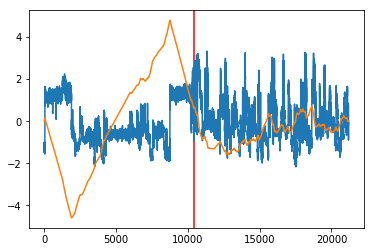

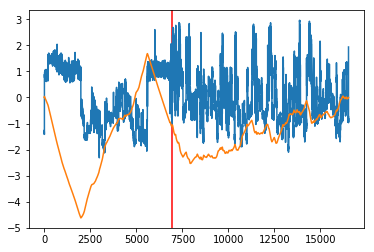

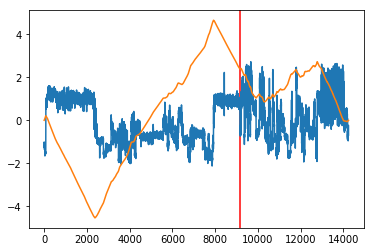

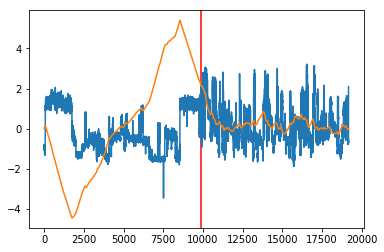

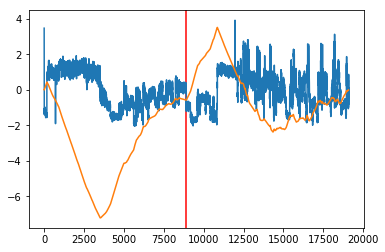

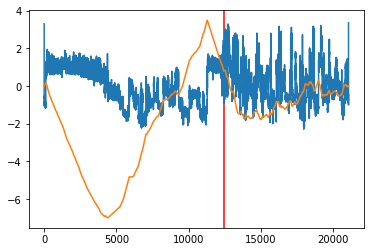

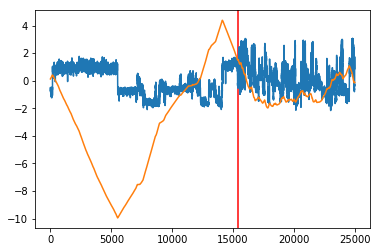

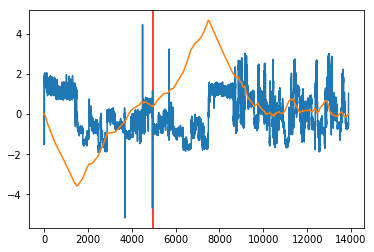

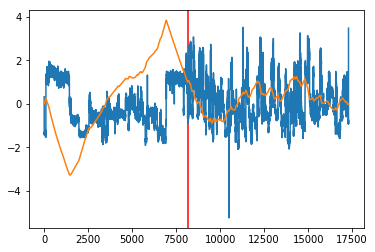

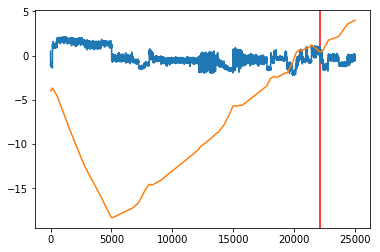

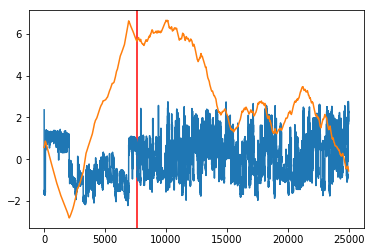

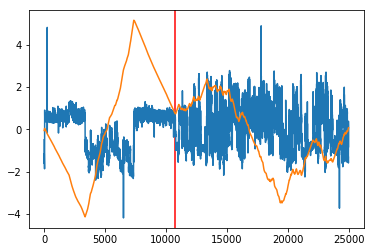

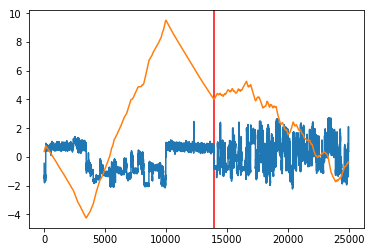

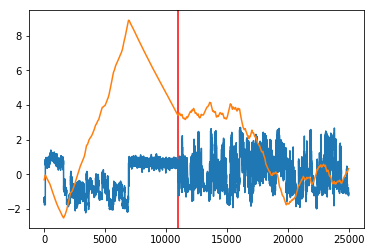

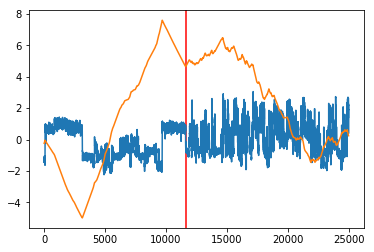

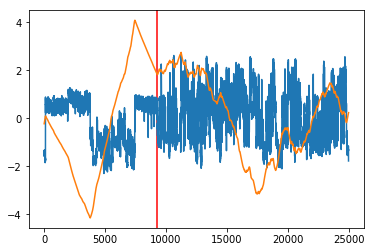

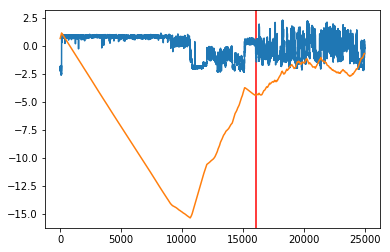

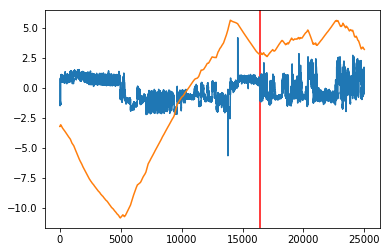

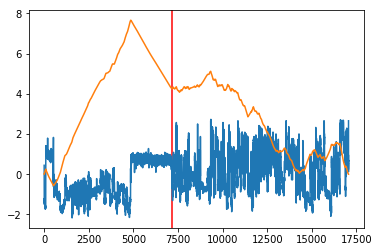

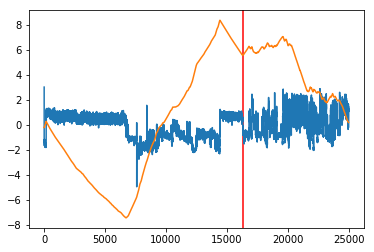

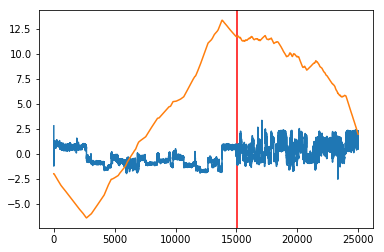

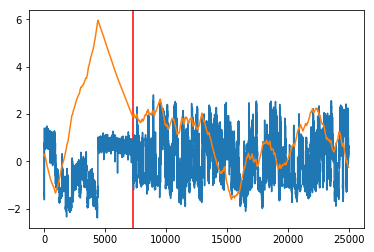

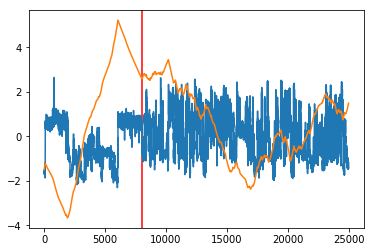

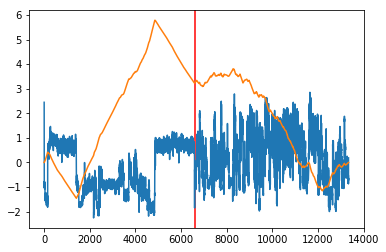

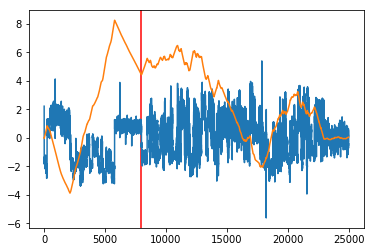

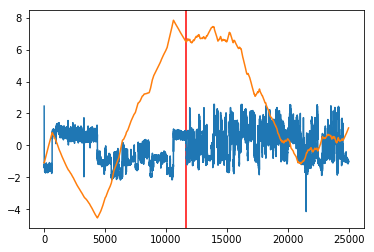

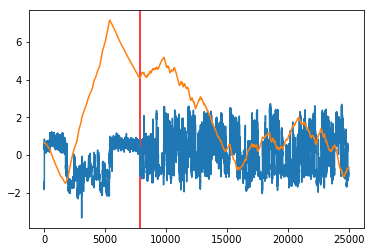

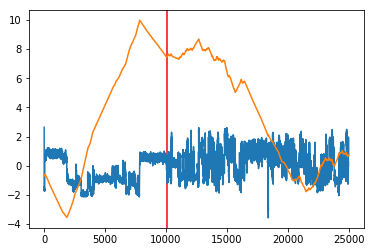

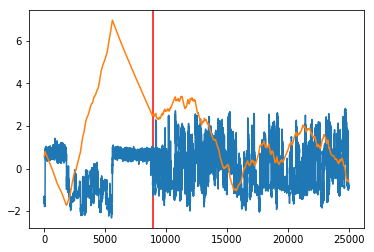

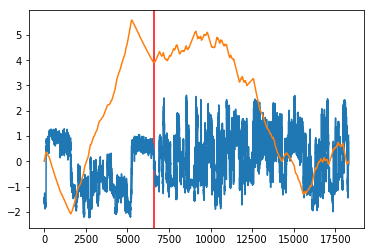

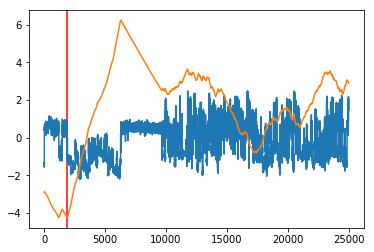

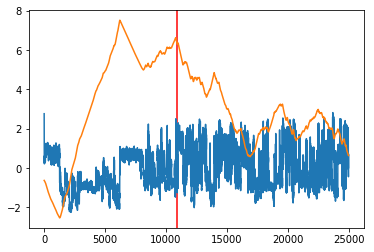

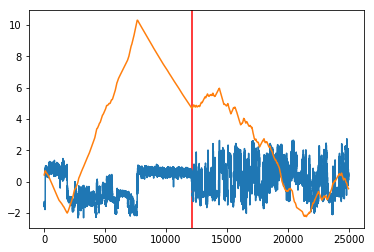

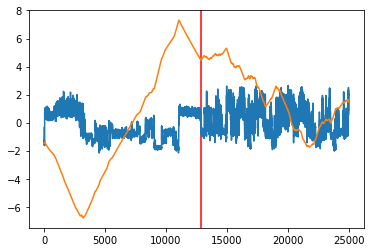

In [408]:
for i, sig in enumerate(signals):
    sig = sig[:25000]
    poly_a, c = find_polyA(sig)
    plt.axvline(poly_a, color='r')
    plt.plot(sig)
    plt.plot(c / 1000)
    plt.show()

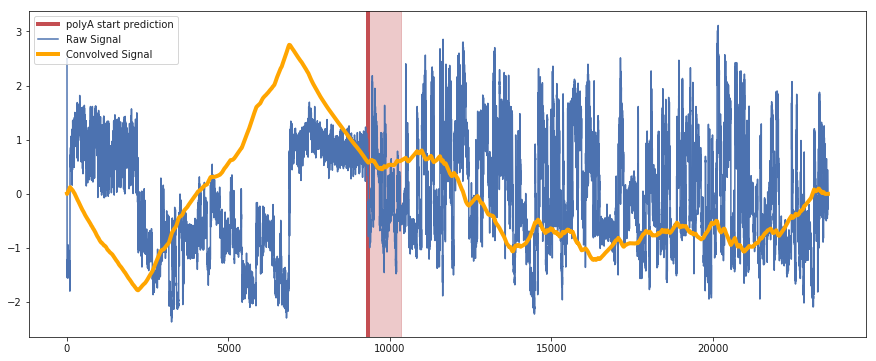

In [458]:
sns.set_color_codes()
fig, ax = plt.subplots(figsize=(15, 6))
poly_a, c = find_polyA(signals[2])
ax.axvline(poly_a, color='r', linewidth=4, label='polyA start prediction')
ax.axvspan(poly_a, poly_a + 1000, color='r', alpha=0.3)
ax.plot(signals[2], color='b', label='Raw Signal')
ax.plot(c / 2000, color='orange', linewidth=4, label='Convolved Signal')
plt.legend()
plt.show()

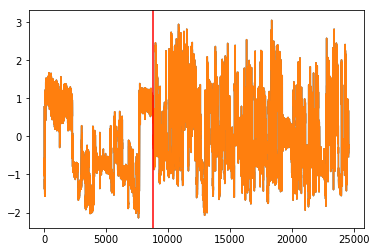

In [412]:
plt.plot(signals[1])
poly_a, c = find_polyA(signals[1])
plt.axvline(poly_a, color='r')
plt.show()

In [435]:
cat = pd.Series(transcripts).astype('category').cat.codes

In [445]:
rus = RandomUnderSampler(ratio=lambda transcripts: {x: 5 for x in set(transcripts)})
idx, y = rus.fit_sample(X=np.arange(len(cat)).reshape(-1, 1), y=cat)
signals_resampled = [s[0] for s in signals[idx]]

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  from ipykernel import kernelapp as app


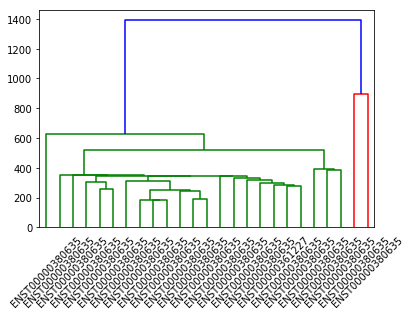

In [446]:
dists = cluster_signals(signals_resampled)
z = linkage(dists)
tree = dendrogram(z, labels=transcripts)
plt.show()

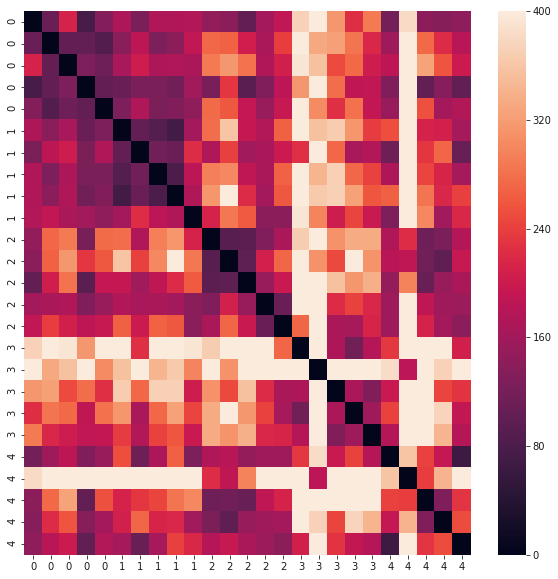

In [460]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(dists, yticklabels=y, xticklabels=y, vmax=400)
plt.show()